### Я спарсил статьи, связанные с машинным обучением

In [ ]:
# !pip install feedparser

In [ ]:
import csv
import itertools
from sklearn.feature_extraction.text import TfidfVectorizer
import networkx as nx
from transformers import pipeline
import csv
import csv
import urllib.parse
import urllib.request
import feedparser
import pandas as pd
import networkx as nx
from itertools import combinations
import matplotlib.pyplot as plt
from collections import Counter
from datetime import datetime

In [ ]:
API = "http://export.arxiv.org/api/query"

QUERY = "machine learning"
OUT_CSV = "arxiv_min.csv"

def fetch(start: int, max_results: int):
    params = {
        "search_query": f"all:{QUERY}",
        "start": start,
        "max_results": max_results,
    }
    url = f"{API}?{urllib.parse.urlencode(params)}"
    with urllib.request.urlopen(url, timeout=60) as r:
        data = r.read()
    return feedparser.parse(data)

In [ ]:
records = []
start = 0
while len(records) < 250:
    feed = fetch(start, 100)
    entries = feed.entries
    if not entries:
        break
    for e in entries:
        title = (e.title or "").strip()
        summary = (getattr(e, "summary", "") or "").strip()
        try:
            authors = [a.name for a in e.authors]
        except Exception:
            authors = [getattr(e, "author", "")] if hasattr(e, "author") else []
        pub_date = getattr(e, "published", "")
        year = None
        if pub_date:
            try:
                year = datetime.strptime(pub_date, "%Y-%m-%dT%H:%M:%SZ").year
            except Exception:
                pass
        records.append({
            "title": title,
            "authors": ", ".join(authors),
            "summary": summary,
            "year": year
        })
    start += len(entries)

records = records[:250]

with open(OUT_CSV, "w", encoding="utf-8", newline="") as f:
    w = csv.DictWriter(f, fieldnames=["title", "authors", "summary", "year"])
    w.writeheader()
    w.writerows(records)

####Aнализ публикаций по годам




In [ ]:
df = pd.DataFrame(records)
year_counts = df["year"].value_counts().sort_index()
year_counts.head(5)

,count
year,
2009,1
2011,1
2012,3
2013,2
2014,2


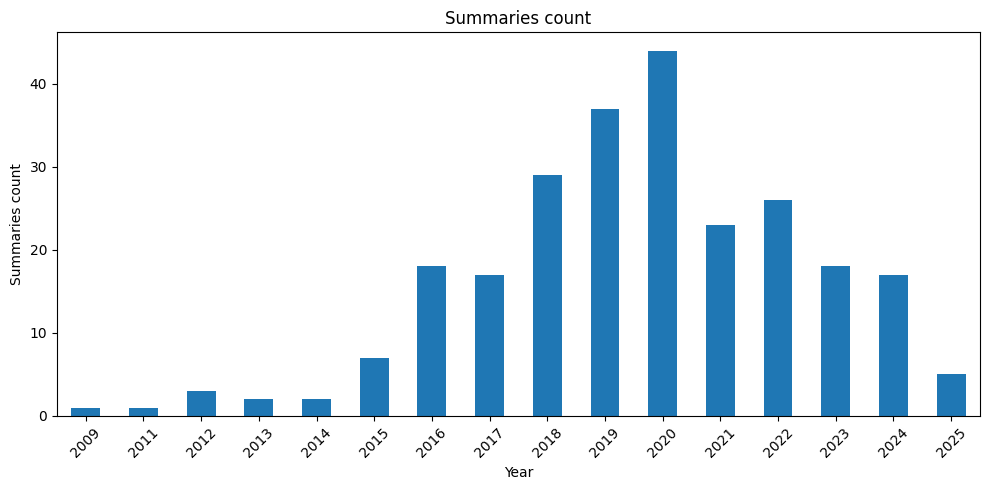

In [ ]:
plt.figure(figsize=(10,5))
year_counts.plot(kind="bar")
plt.title("Summaries count")
plt.xlabel("Year")
plt.ylabel("Summaries count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

После 2015-го заметен резкий скачок

Почему-то публикаций после 2020-го становится меньше. Возможно, потому что я спарсил не все статьи

In [ ]:
all_authors = []
for rec in records:
    authors = [a.strip() for a in rec["authors"].split(",") if a.strip()]
    all_authors.extend(authors)

author_counts = Counter(all_authors)
top_authors = author_counts.most_common(10)

print("Топ-10 авторов:")
for author, count in top_authors:
    print(f"{author}: {count}")

Топ-10 авторов:
Been Kim: 5
Kush R. Varshney: 4
Jialei Wang: 3
Mladen Kolar: 3
Nathan Srebro: 3
William Herlands: 3
Wei-Hung Weng: 2
Xia Hu: 2
Lucas Lamata: 2
Yuan Tang: 2


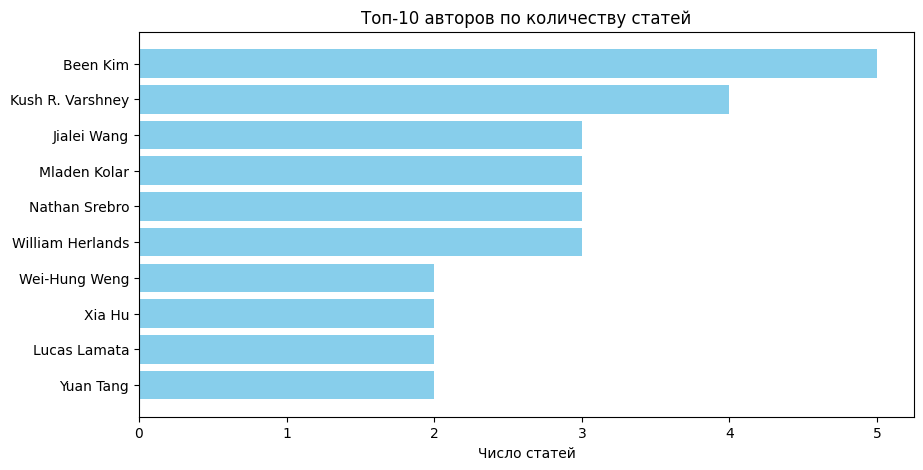

In [ ]:
df_authors = pd.DataFrame(top_authors, columns=["author", "count"])

plt.figure(figsize=(10,5))
plt.barh(df_authors["author"], df_authors["count"], color="skyblue")
plt.gca().invert_yaxis()
plt.title("Топ-10 авторов по количеству статей")
plt.xlabel("Число статей")
plt.show()

In [ ]:
pipe = pipeline("text2text-generation", model="ilsilfverskiold/tech-keywords-extractor")

In [ ]:
docs = []
with open("arxiv_min.csv", encoding="utf-8") as f:
    r = csv.DictReader(f)
    for row in r:
        text = f"{row['title']} {row['summary']}"
        docs.append(text)

In [ ]:
results = []
for text in docs:
    out = pipe(text, max_length=64, clean_up_tokenization_spaces=True)[0]["generated_text"]
    keywords = [k.strip() for k in out.split(",") if k.strip()]
    results.append(keywords)

with open("keywords_extracted.csv", "w", encoding="utf-8", newline="") as f:
    w = csv.writer(f)
    w.writerow(["doc_id", "keywords"])
    for i, kws in enumerate(results):
        w.writerow([i, "|".join(kws)])

In [ ]:
nodes_by_doc = []
for i, kws in enumerate(results):
    nodes_by_doc.append({"doc_id": i, "keywords": "|".join(kws)})

df = pd.DataFrame(nodes_by_doc)
df.to_csv("keywords_extracted.csv", index=False)

In [ ]:
len(results)

250

###Построение графа

In [ ]:
G = nx.Graph()

for kws in results:
    for kw in kws:
        if not G.has_node(kw):
            G.add_node(kw)
    for u, v in combinations(sorted(kws), 2):
        if G.has_edge(u, v):
            G[u][v]["weight"] += 1
        else:
            G.add_edge(u, v, weight=1)

In [ ]:
print(f'{G.number_of_nodes()} узлов, {G.number_of_edges()} рёбер.')

760 узлов, 1932 рёбер.


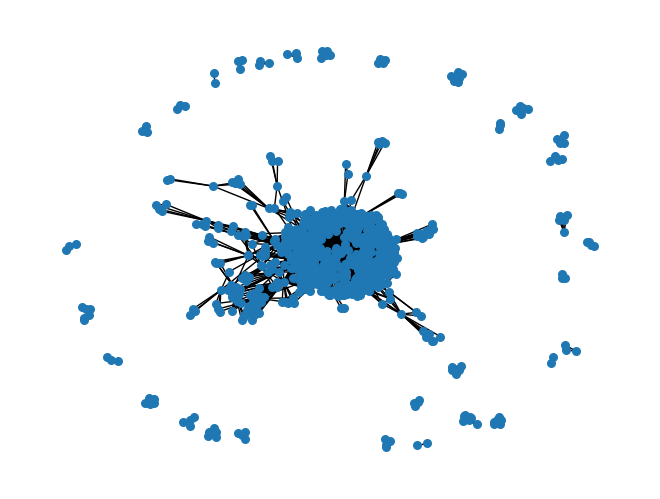

In [ ]:
nodes_df = pd.DataFrame({"id": list(G.nodes)})
nodes_df.to_csv("keywords_nodes.csv", index=False)

edges_df = nx.to_pandas_edgelist(G)
edges_df.to_csv("keywords_edges.csv", index=False)

nx.draw(G, with_labels=False, font_weight='bold', node_size=30)

In [ ]:
communities = nx.community.louvain_communities(G, resolution=0.9)
print(f"# of clusters: {len(communities)}, Modularity: {nx.community.modularity(G, communities)}")

# of clusters: 64, Modularity: 0.6769049504116723


53 кластера - много относительно небольших тематических групп ключевых слов.

Modularity = 0.67 - разбиение получилось качественным(если больше 0.3 - значит норм)

In [ ]:
deg_cent = nx.degree_centrality(G)

deg_df = pd.DataFrame(
    sorted(deg_cent.items(), key=lambda x: x[1], reverse=True)[:5],
    columns=["keyword", "degree_centrality"]
)

In [ ]:
print(deg_df.to_string(index=False))

               keyword  degree_centrality
      Machine Learning           0.620553
         Deep Learning           0.086957
                Python           0.044796
Reinforcement Learning           0.032938
       Neural Networks           0.031621


Изначально я хотел использовать Eigenvector centrality - важность по связям, но у меня граф несвязный (760 узлов и всего 1932 ребра, то есть много висячих компонент), поэтому решил выбрать классическую degree centrality

degree centrality показывает количество связей у узла(их долю), у меня очень много связей у "machine learning", у остальных слов намного меньше

Degree = популярность.

Betweenness = связующее звено.

Eigenvector = ядро тематики.

Closeness = универсальность/доступность.

In [ ]:
import networkx as nx
import pandas as pd

def build_publication_graph(results):
    H = nx.Graph()
    for i in range(len(results)):
        H.add_node(i)
    for i in range(len(results)):
        for j in range(i + 1, len(results)):
            common = set(results[i]) & set(results[j])
            if common:
                H.add_edge(i, j, weight=len(common))
    return H

H = build_publication_graph(results)
print(f"{H.number_of_nodes()} документов, {H.number_of_edges()} связей.")

nodes_df = pd.DataFrame({"id": [f"doc_{i}" for i in H.nodes]})
nodes_df.to_csv("pub_nodes.csv", index=False)

edges_df = nx.to_pandas_edgelist(H)
edges_df.to_csv("pub_edges.csv", index=False)

def find_similar_pubs(H, doc_id, top_k=5):
    if doc_id not in H:
        return []
    neighbors = H[doc_id]
    ranked = sorted(neighbors.items(), key=lambda x: x[1]["weight"], reverse=True)
    return [(v, d["weight"]) for v, d in ranked[:top_k]]

# пример
print(find_similar_pubs(H, doc_id=0, top_k=5))

250 документов, 13525 связей.
[(16, 2), (40, 2), (216, 2), (218, 2), (2, 1)]


Поиск ближайших - это просто выбор соседей узла с максимальными количеством общих клучевых слов между публикациями

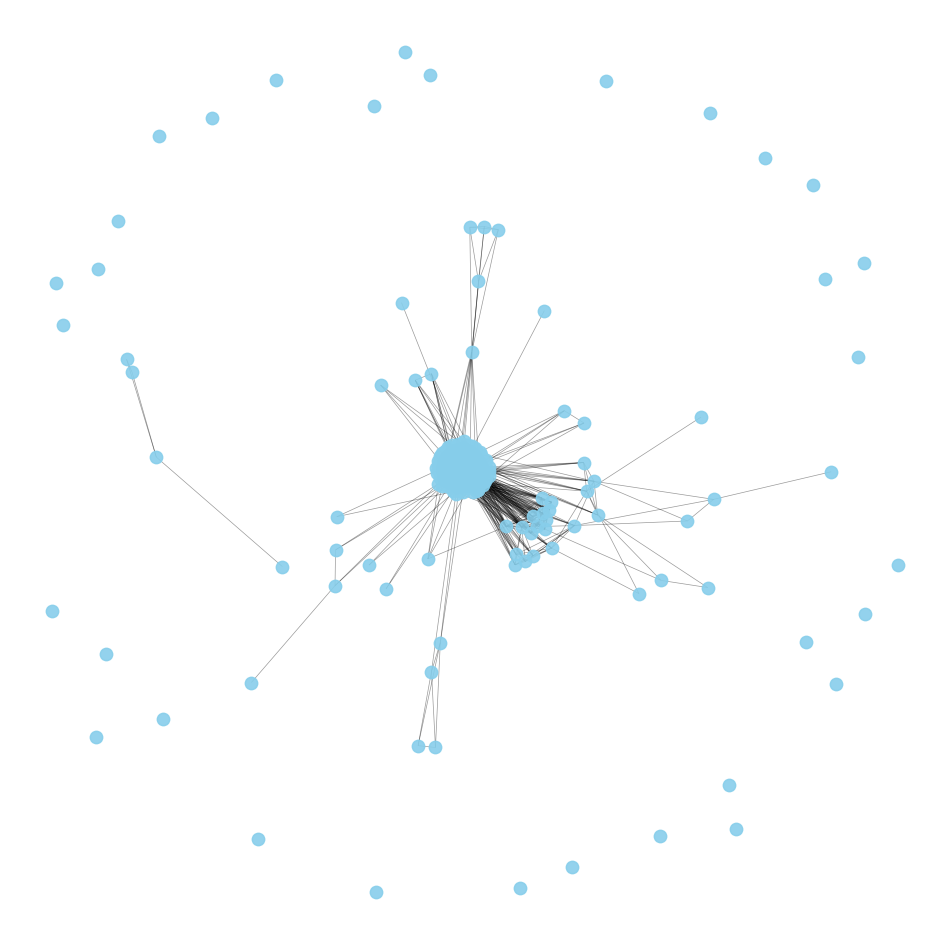

In [ ]:
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(H, k=0.2, seed=42)

edges = H.edges(data=True)
weights = [d["weight"] for (_, _, d) in edges]

nx.draw_networkx_nodes(H, pos, node_size=80, node_color="skyblue", alpha=0.9)
nx.draw_networkx_edges(H, pos, width=[w*0.5 for w in weights], alpha=0.4)

plt.axis("off")
plt.show()

Для обоих графов можно сделать вывод, что есть множество слов, с которыми плотно связано большинство статей, однако есть несколько терминов, которые являются, возможно, узко-специлизированными, поэтому некоторые статьи находятся далеко от центра и не соеденины ребрами с другими